# Spectral denoising as feature engineering

In this notebook we investigate the use of Fourier and Wavelet tranforms as a denosing pre-processing step prior to time series forecasting. This approach can be summarised as:
- step 1: Spectral tranforms of time series data, a transform from the time to frequency domain
- step 2: filter out high frequency noise components.
- step 3: inverses tranforms the frequency signal back to the time domain.
- step 4: forecasting the denoised signal. 

In [1]:
# import bespoke modules
from src.one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2, invert_scaling,inverted_conclusion
from src.walkforward_validation import walk_forward_val, series_to_supervised
from src.spectral_denoising import automatic_fourier_denoising, automatic_fourier_denoising_wf, automatic_wavelet_denoising, automatic_wavelet_denoising_wf

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tabulate import tabulate

2022-06-28 10:58:23.867527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 10:58:23.867579: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv(f'./test_data/EurUsd_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df

Date      Open      High       Low     Close  Adj Close  Volume
0     2014-04-29  1.385291  1.387900  1.380741  1.385291   1.385291       0
1     2014-04-30  1.381387  1.387700  1.378660  1.381368   1.381368       0
2     2014-05-01  1.386866  1.389101  1.386399  1.386924   1.386924       0
3     2014-05-02  1.387097  1.387099  1.381349  1.387097   1.387097       0
4     2014-05-05  1.387270  1.388800  1.386597  1.387270   1.387270       0
...          ...       ...       ...       ...       ...        ...     ...
1995  2021-12-24  1.132464  1.134430  1.130838  1.132734   1.132734       0
1996  2021-12-27  1.132387  1.133500  1.130416  1.132426   1.132426       0
1997  2021-12-28  1.132978  1.133600  1.129038  1.133003   1.133003       0
1998  2021-12-29  1.131337  1.137001  1.127536  1.131478   1.131478       0
1999  2021-12-30  1.135976  1.135976  1.130071  1.136015   1.136015       0

[2000 rows x 7 columns]

# 1. Fourier methods

Trial 20 Complete [00h 00m 42s]
val_loss: 0.0018212971976026894

Best val_loss So Far: 0.0010003673960454762
Total elapsed time: 00h 28m 23s
INFO:tensorflow:Oracle triggered exit
Best LSTM hyperparamteres: <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7ff241322760>
Epoch 1/2000
24/24 [==============================] - 3s 52ms/step - loss: 0.0498
Epoch 2/2000
24/24 [==============================] - 1s 52ms/step - loss: 0.0051
Epoch 3/2000
24/24 [==============================] - 1s 52ms/step - loss: 0.0012
Epoch 4/2000
24/24 [==============================] - 1s 52ms/step - loss: 0.0011
Epoch 5/2000
24/24 [==============================] - 1s 52ms/step - loss: 0.0011
Epoch 6/2000
24/24 [==============================] - 1s 53ms/step - loss: 0.0011
Epoch 7/2000
24/24 [==============================] - 1s 51ms/step - loss: 0.0012
Epoch 8/2000
24/24 [==============================] - 1s 51ms/step - loss: 0.0011
Epoch 9/2000
24/24 [==============================] - 1s 53m

/tmp/ipykernel_22629/3040275078.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
/tmp/ipykernel_22629/3040275078.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
/tmp/ipykernel_22629/3040275078.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Movement prediction accuracy: 59.2 %
Confusion matrix:
[[116 116]
 [ 88 180]]
Movement prediction accuracy: 56.0 %
Confusion matrix:
[[ 99 133]
 [ 87 181]]
Movement prediction accuracy: 59.2 %
Confusion matrix:
[[112 120]
 [ 84 184]]
Movement prediction accuracy: 57.6 %
Confusion matrix:
[[137  95]
 [117 151]]
+----+-------------------+----------+----------+-----------+-------+
|    | model             |     RMSE |      MAE |      MAPE |    DA |
|----+-------------------+----------+----------+-----------+-------|
|  0 | Linear Regression |  2.33641 |  1.78302 | 0.0157501 | 0.592 |
|  1 | SVM               |  4.98255 |  4.05498 | 0.0361448 | 0.56  |
|  2 | MLP               |  5.23162 |  4.08628 | 0.0322432 | 0.592 |
|  3 | LSTM              | 55.0776  | 41.3927  | 0.299111  | 0.576 |
+----+-------------------+----------+----------+-----------+-------+


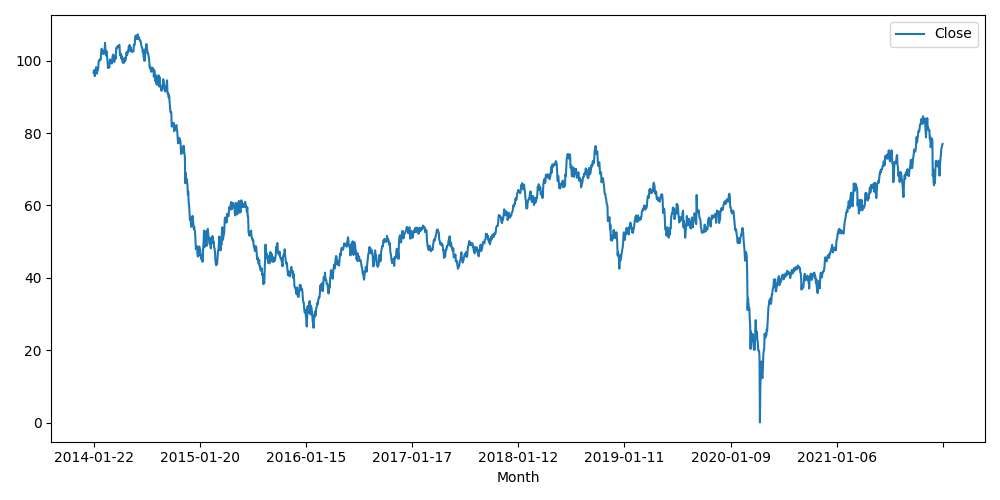

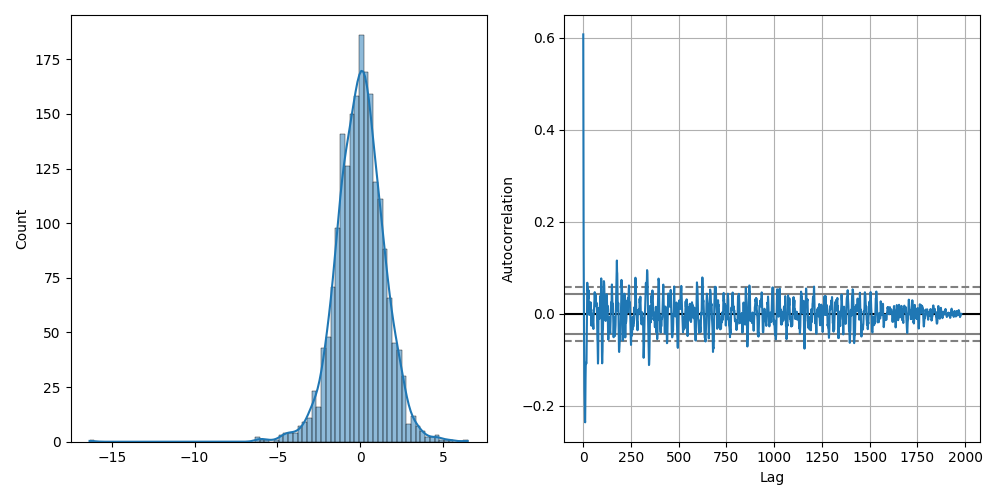

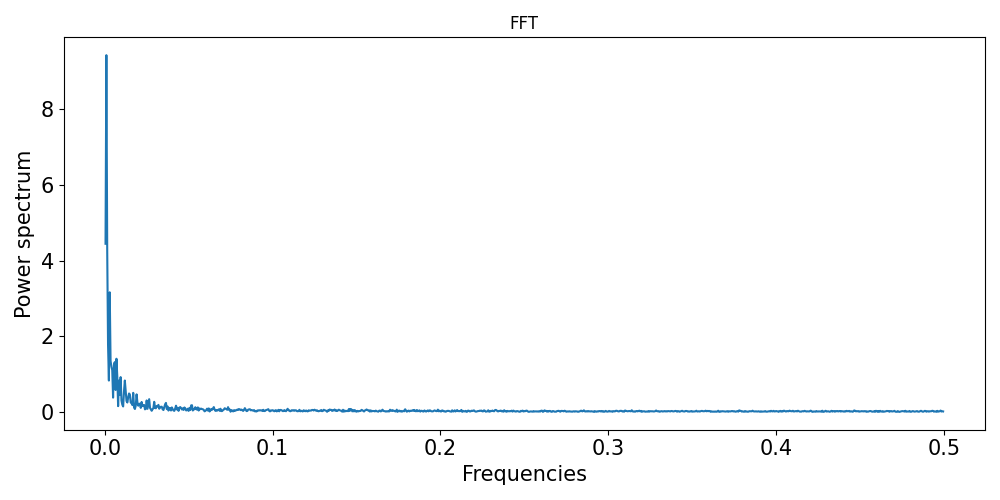

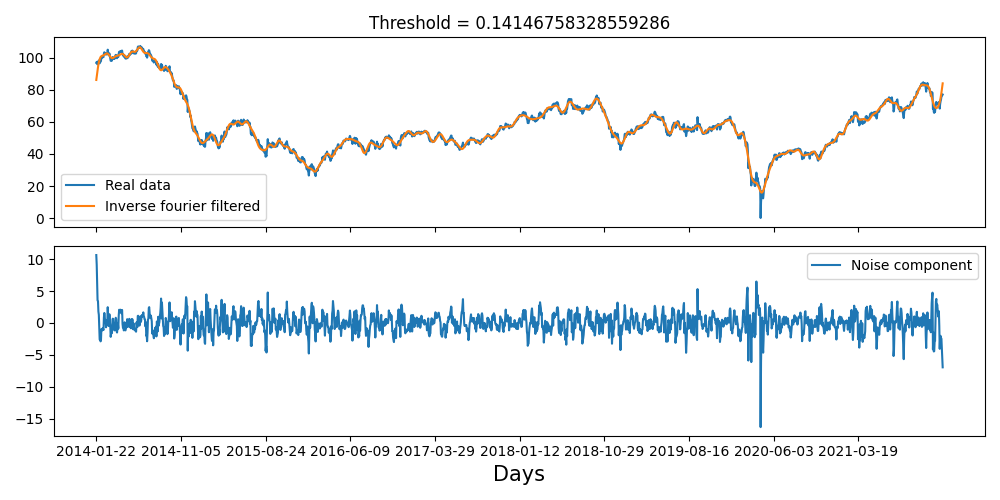

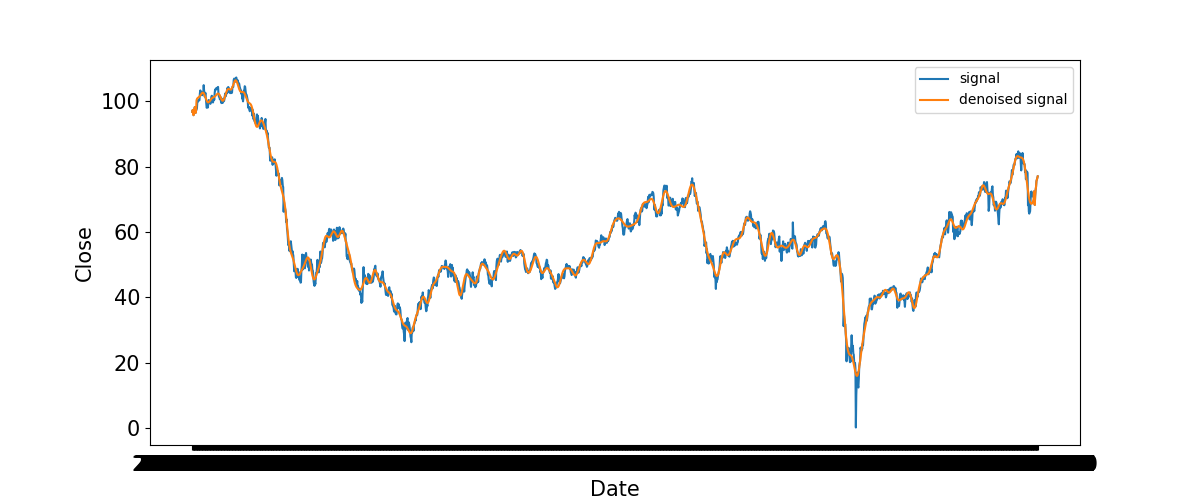

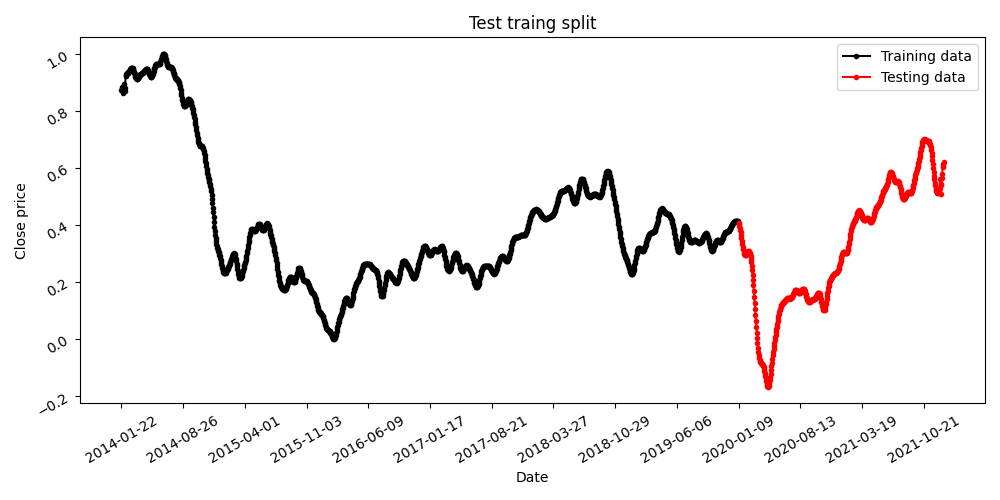

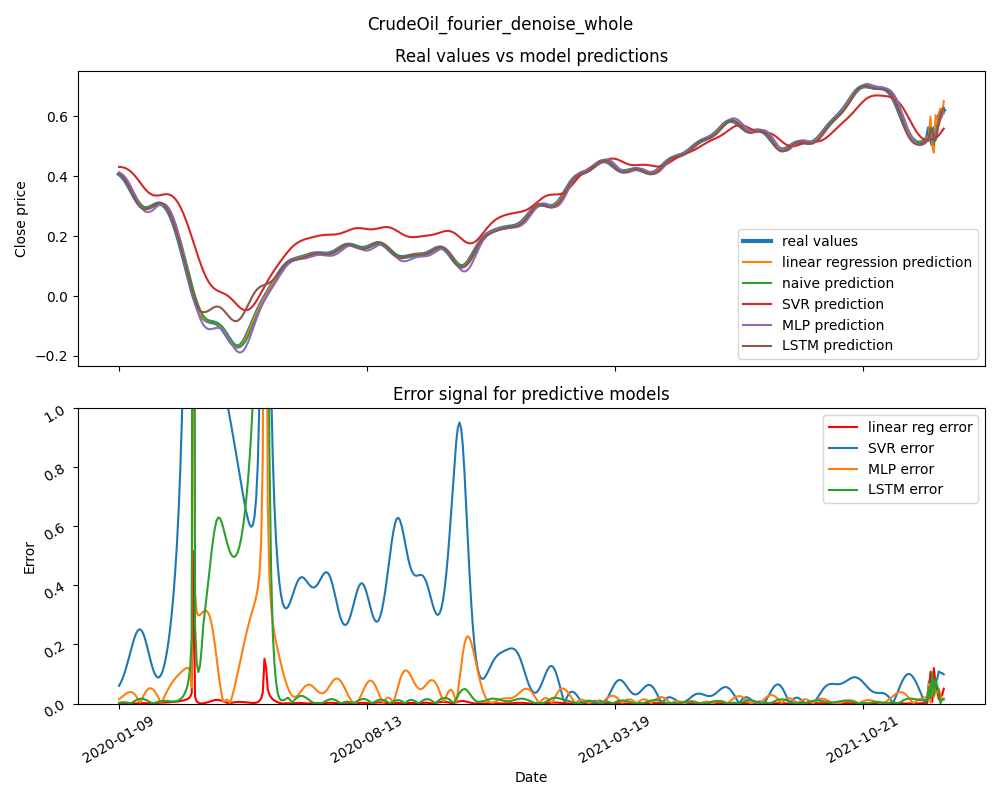

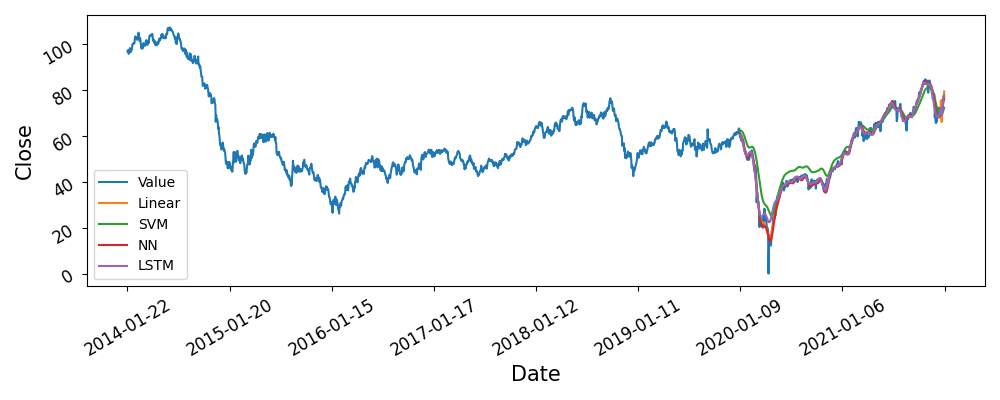

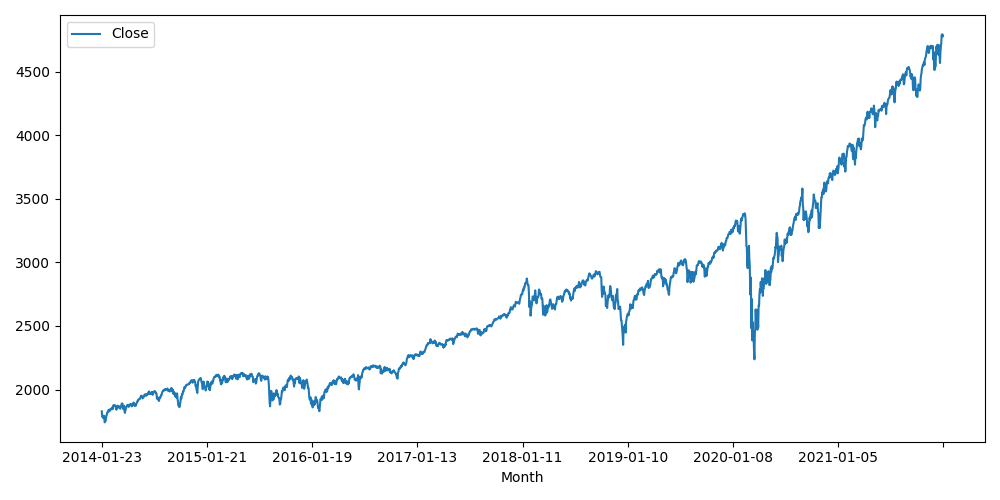

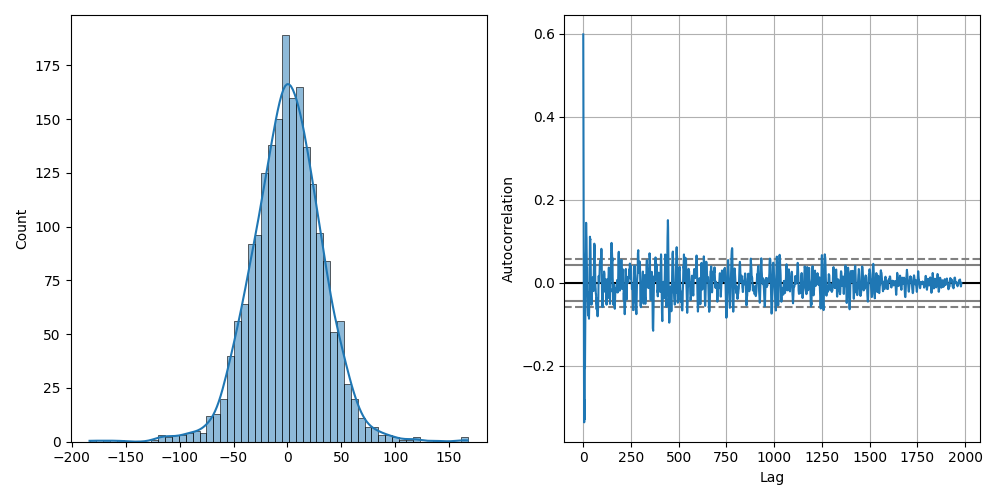

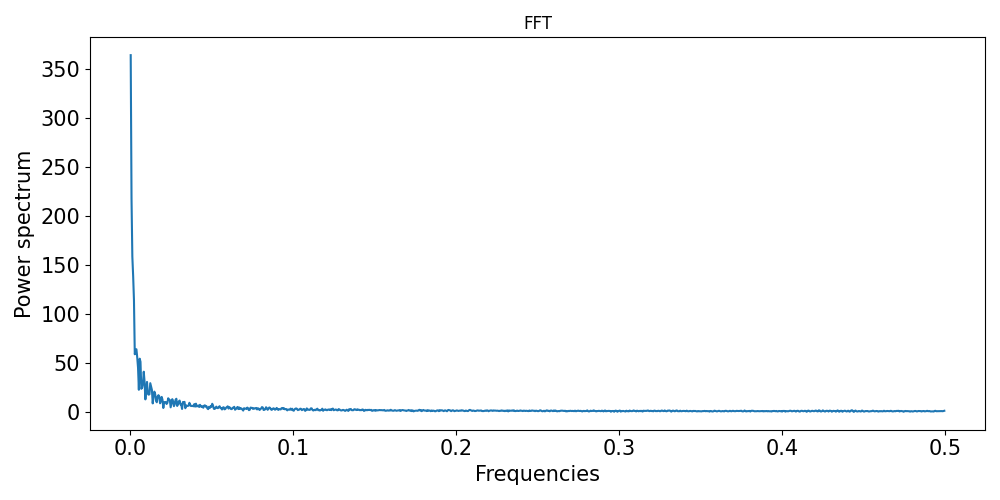

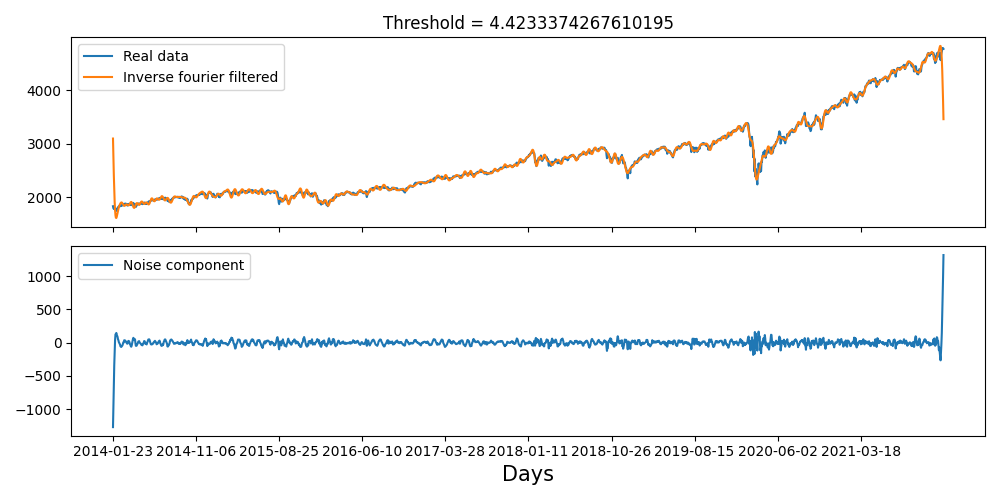

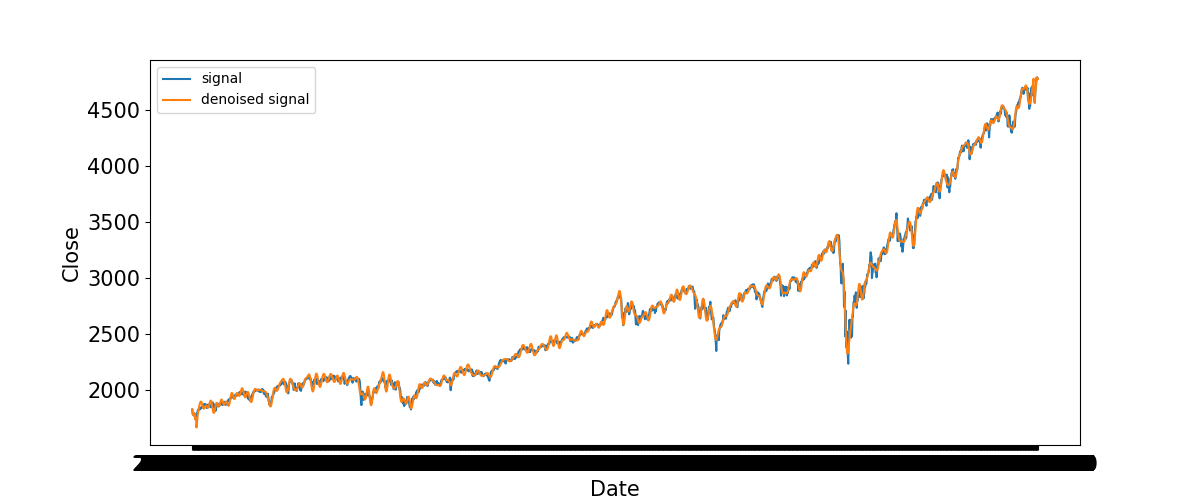

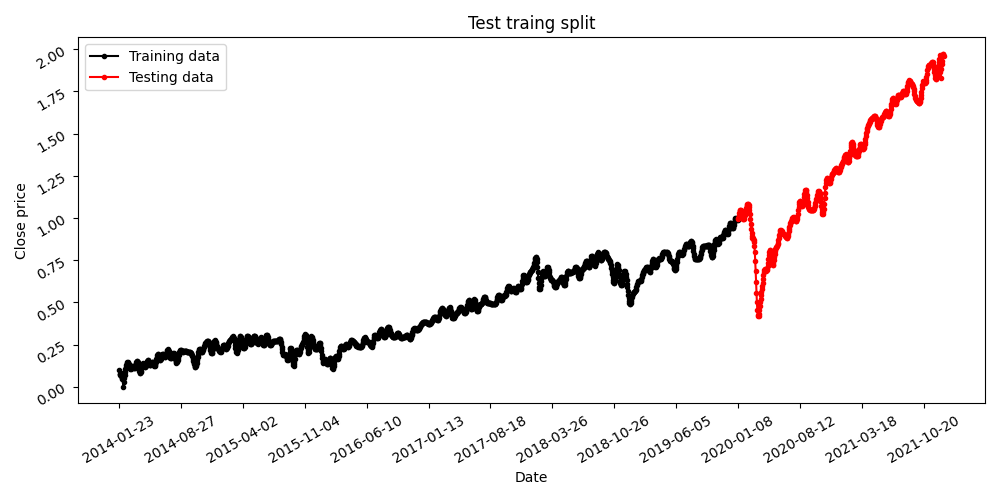

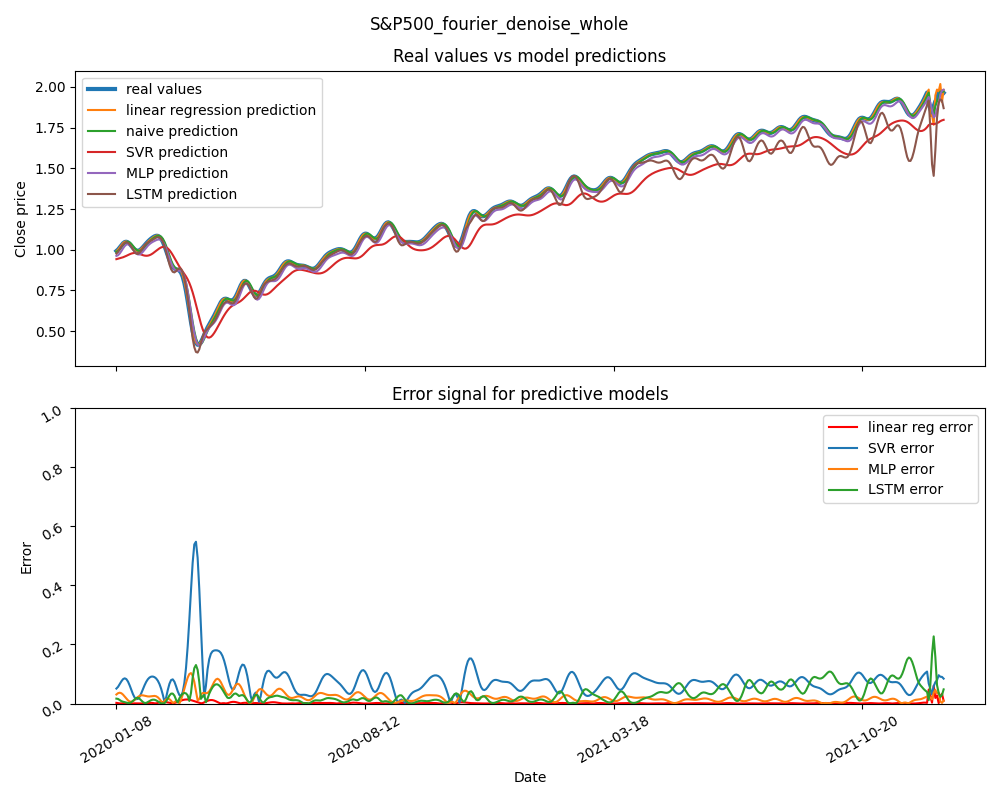

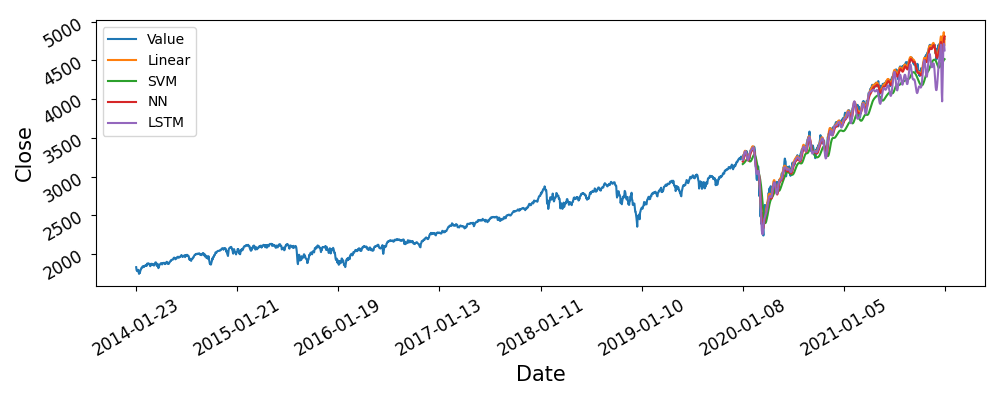

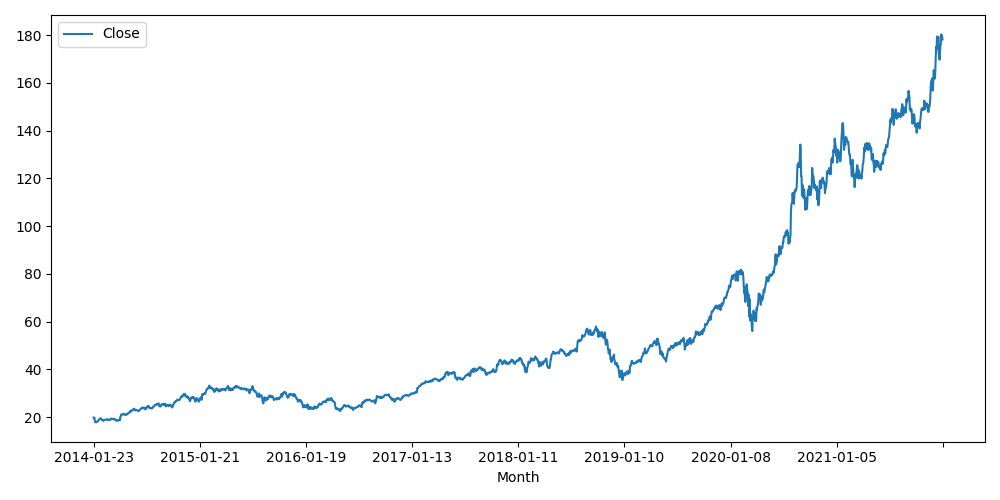

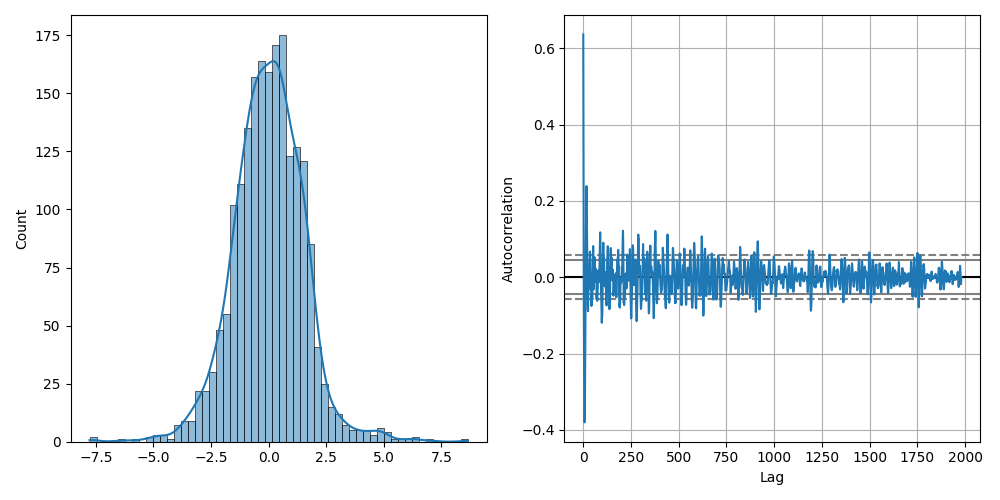

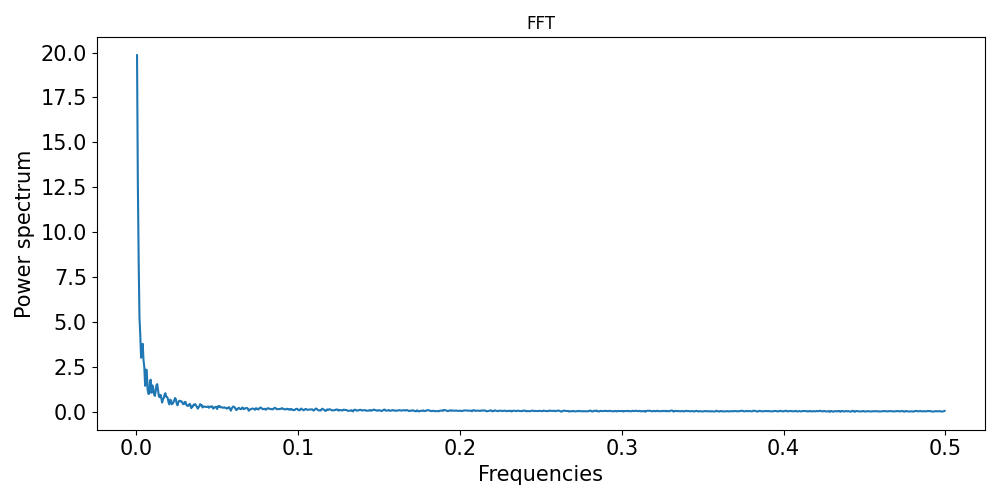

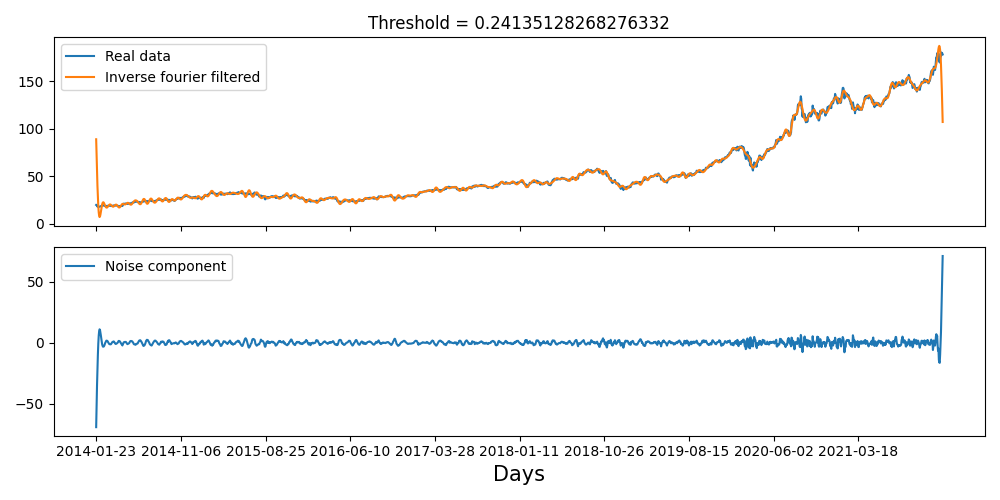

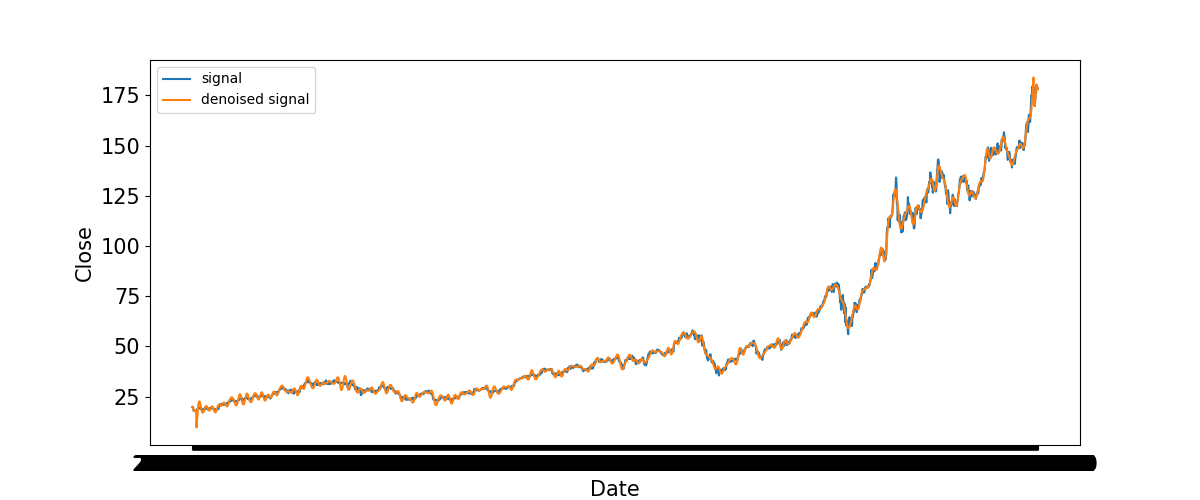

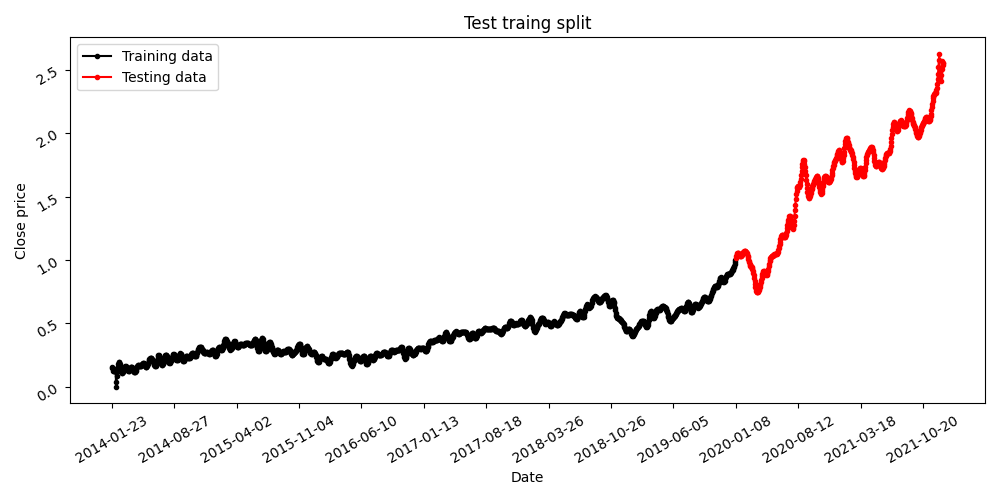

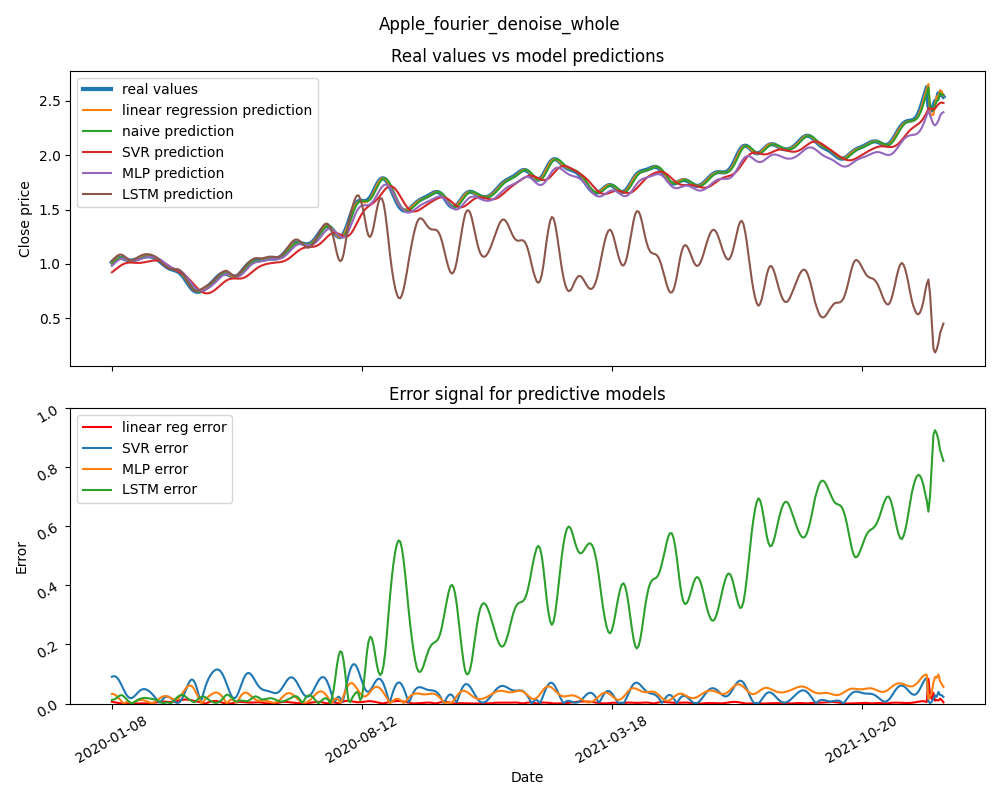

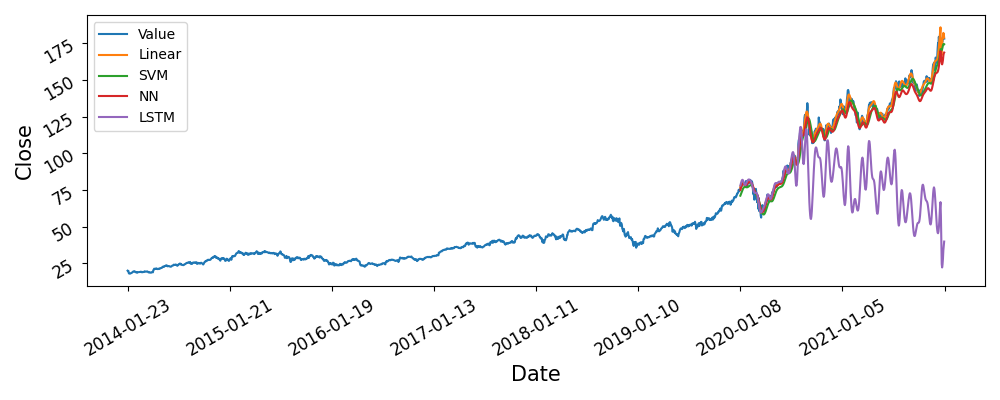

In [11]:
financial_assets = ['CrudeOil','S&P500','Apple']#['EurUsd']# ,'EurUsd'] # AirPassengers',
feat_engineering = 'fourier_denoise_whole'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # fft the testing data - used in thesis
    # signal = np.array(df[f'{column_to_predict}'][-200:]) # data -split !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! wrong
    # denoised_signal = automatic_fourier_denoising(signal,df, split=500,verbose=True)

    # fft eyeball + denoise whole signal
    signal = np.array(df[f'{column_to_predict}'][-2000:]) 
    dates = df['Date'].iloc[-2000:]
    denoised_signal = automatic_fourier_denoising(signal,
                                                  dates,
                                                     verbose=True)

    plt.figure(figsize=(12,5))
    plt.plot(dates,signal,label='signal')
    plt.plot(dates,denoised_signal,label='denoised signal')
    plt.ylabel('Close',fontsize=15)
    plt.xlabel('Date',fontsize=15)
    plt.tick_params(labelsize=15)
    plt.legend()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_denoise_whole_.png',facecolor='w')


    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # # input data - denosing only test set
    # scaler = MinMaxScaler()
    # scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    # scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    # scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # input data - denosing whole signal
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal[:-split].reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(denoised_signal[-split:].reshape(-1, 1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)    

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=df[f'{column_to_predict}'].iloc[-split:], 
                        linear_preds=inverted_predictions_linear, 
                        svm_pred=inverted_predictions_svm, 
                        nn_preds=inverted_predictions_nn, 
                        lstm_preds=inverted_predictions_lstm,
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)

    # ###################################################################################################
    # # walk forward validation results
    # ###################################################################################################
    # mapping = {'LinearReg':blah.linear_regression_model,
    #             'svr':blah.svr_model,
    #             'MLP':blah.mlp_model,
    #             'LSTM':blah.lstm_model}

    # # store evaulation results for different models
    # model_results = []
    # inverted_results = []
    # model_pred_results = {'Original Values':None,
    #             'LinearReg':None,
    #             'svr':None,
    #             'MLP':None,
    #             'LSTM':None,
    #             }

    # # unfeature engineered data for walkforward
    # walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

    # # apply walkforward for all models
    # for model_name in mapping.keys():

    #     # retrieve model
    #     model = mapping[model_name]

    #     # apply walk forward and save results
    #     train_len = 225 # 48 for Airplane
    #     test_len = 25   # 12 for Airplane
    #     df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,model,
    #                                                                                 original_series = walk_forward_input,
    #                                                                                 time_series_dates=df['Date'].iloc[-2000:],
    #                                                                                 lag_window_length=window_length,
    #                                                                                 train_len=train_len,
    #                                                                                 test_len=test_len,
    #                                                                                 train_frequency=10,
    #                                                                                 transformer=automatic_fourier_denoising_wf,
    #                                                                                 only_training=False,
    #                                                                                 verbose=False,
    #                                                                                 threshold_override=False,
    #                                                                                 threshold=0.05
    #                                                                                 )
    #     # wrangle results

    #     # tables 
    #     model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

    #     # invert results for different models

    #     # invert scaling
    #     inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())

    #     invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions))
    #     invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
    #     invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
    #     df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
    #                                     original_values=df[f'{column_to_predict}'].iloc[train_len:],
    #                                     predictions=inverted_predictions)

    #     inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


    #     # save prediction so we can view inverted walk forward results too
    #     model_pred_results['Original Values'] = df[f'{column_to_predict}'].iloc[train_len:]
    #     model_pred_results[model_name] = inverted_predictions.flatten()

    #     # plots
    #     df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']) / df_walk_forward['real_value'])
        
    #     fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
    #     ax[0].plot(df['Date'].iloc[train_len:],df[f'{column_to_predict}'].iloc[train_len:])
    #     ax[0].set_ylabel('Close')

    #     ax[1].plot(df['Date'].iloc[train_len:],df_walk_forward['error'],color='tab:orange')
    #     ax[1].set_title('Walk forward error through time')
    #     ax[1].set_xlabel('Dates')
    #     ax[1].legend()
    #     ax[1].set_ylim([0,1])

    #     max = df_walk_forward.shape[0]
    #     ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
    #     ax[1].tick_params(rotation=30)
    #     ax[1].set_ylabel('Error')
    #     ax[1].set_xlabel('Date')
    #     plt.tight_layout()
    #     plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
    #     plt.close()
        
    # # place wf results into df, save to csv and latex table
    # df_conclusion_wf = pd.DataFrame.from_records(model_results)
    # df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
    
    # df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
    # df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
    
    
    # latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    # with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
    #     my_latex_table.write(latex_table)

    # latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
    # with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
    #     my_latex_table.write(latex_table)

    # # plot wf prediction results through time
    # for model in model_pred_results.keys():
    #     model_pred_results[model] = model_pred_results[model].astype(float)

    # model_pred_results['Date'] = df['Date'].iloc[train_len:]
    # df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    # ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    # ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    # ax.set_xlabel(xlabel='Date',fontsize=15)
    # ax.tick_params(labelsize=12,rotation=30)

    # plt.tight_layout()
    # plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')


In [6]:
scaled_input_data.shape

(2500,)

# 2. Wavelet methods

In [ ]:
# for wavelet in ['db20','coif8']:

financial_assets = ['CrudeOil','S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = f'wavelet_wrong'
column_to_predict = 'Close' #'#Passengers' 
wavelet = 'sym8'

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # fft the testing data
    signal = np.array(df[f'{column_to_predict}'][-2000:]) # data -split !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    denoised_signal = automatic_wavelet_denoising(signal,df, split,
                                                    verbose=True,
                                                    wavelet=wavelet,
                                                    threshold_override=False, 
                                                    threshold=0.4)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=df[f'{column_to_predict}'].iloc[-split:], 
                        linear_preds=inverted_predictions_linear, 
                        svm_pred=inverted_predictions_svm, 
                        nn_preds=inverted_predictions_nn, 
                        lstm_preds=inverted_predictions_lstm,
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model
                }

    # store evaulation results for different models
    model_results = []
    inverted_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # unfeature engineered data for walkforward
    walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,model,
                                                                                    original_series = walk_forward_input,
                                                                                    time_series_dates = df['Date'].iloc[-2000:],
                                                                                    lag_window_length=window_length,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10,
                                                                                    transformer=automatic_wavelet_denoising_wf,
                                                                                    only_training=False,
                                                                                    verbose=False,
                                                                                    wavelet=wavelet,
                                                                                    threshold_override=False)
        # wrangle results

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # invert results for different models

        # invert scaling
        inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())

        invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions))
        invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
        invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
        df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                        original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                        predictions=inverted_predictions)

        inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df[f'{column_to_predict}'].iloc[train_len:]
        model_pred_results[model_name] = inverted_predictions.flatten()

        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']) / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df['Date'].iloc[train_len:],df[f'{column_to_predict}'].iloc[train_len:])
        ax[0].set_ylabel('Close')

        ax[1].plot(df['Date'].iloc[train_len:],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()
        ax[1].set_ylim([0,1])

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
    
    df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
    df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')

# 3. Moving averages

In [ ]:
# moving average function for feature engineering during walk forward validation
def moving_average_wf(signal,moving_average):
    # numpy array to pandas series
    series = pd.Series(signal)

    # smoothen
    series_smooth = series.rolling(moving_average,min_periods=1).mean().to_numpy()

    return series_smooth
    

In [ ]:
import copy

financial_assets = ['CrudeOil','S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'moving_average_wrong'
column_to_predict = 'Close' #'#Passengers' 


for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # smoothen data
    moving_average = 10
    signal = copy.deepcopy(df[f'{column_to_predict}'][-2000:]) # data -split !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    denoised_signal = signal.rolling(moving_average,min_periods=1).mean().to_numpy()

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df['Date'][:-split], df[f'{column_to_predict}'][:-split],label='Raw signal')
    ax.plot(df['Date'][:-split], denoised_signal,label=f"MA_{moving_average}") 
    max = df.iloc[:-split,:].shape[0]
    relevant_dates = df['Date'][:-split]
    ax.set_xticks([relevant_dates.iloc[x] for x in range(0,max,150)])
    plt.legend()
    plt.tight_layout()
    display(df)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    # scaler = MinMaxScaler()
    # scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    # scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    # scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # for wrong test input data
    scaler = MinMaxScaler()
    scaled_input_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # invert feature engineering (if possible)
    ###################################################################################################

    # invert scaling
    inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
    inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
    inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
    inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

    # collect inverted results

    df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
    df_inverted_results['Date'] = df['Date']
    df_inverted_results['Value'] = df[f'{column_to_predict}']
    df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
    df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

    # plot invert results
    ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(rotation=30, labelsize=12)    
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

    # store results
    inverted_conclusion(dates=df['Date'].iloc[-split:],
                        original_values=df[f'{column_to_predict}'].iloc[-split:], 
                        linear_preds=inverted_predictions_linear, 
                        svm_pred=inverted_predictions_svm, 
                        nn_preds=inverted_predictions_nn, 
                        lstm_preds=inverted_predictions_lstm,
                        financial_asset=financial_asset,
                        feat_engineer=feat_engineering)

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model
                }

    # store evaulation results for different models
    model_results = []
    inverted_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # unfeature engineered data for walkforward
    walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,
                                                                            model=model,
                                                                            original_series = walk_forward_input,
                                                                            time_series_dates = df[f'Date'].iloc[-2000:],
                                                                            lag_window_length= 10,
                                                                            train_len=225,
                                                                            test_len=25,
                                                                            train_frequency=10,
                                                                            transformer=moving_average_wf,
                                                                            only_training=False,
                                                                            moving_average=moving_average,
                                                                            )
        # wrangle results

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # invert results for different models

        # invert scaling
        inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())

        invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions))
        invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
        invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
        df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                        original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                        predictions=inverted_predictions)

        inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df[f'{column_to_predict}'].iloc[train_len:]
        model_pred_results[model_name] = inverted_predictions.flatten()

        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']) / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df['Date'].iloc[train_len:],df[f'{column_to_predict}'].iloc[train_len:])
        ax[0].set_ylabel('Close')

        ax[1].plot(df['Date'].iloc[train_len:],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()
        ax[1].set_ylim([0,1])

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
    
    df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
    df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')


# 4. Exponentially weighted moving average

In [ ]:
# moving average function for feature engineering during walk forward validation
def ewma_wf(signal,alpha):
    # numpy array to pandas series
    series = pd.Series(signal)

    # smoothen
    series_smooth = series.ewm(alpha=alpha).mean().to_numpy()

    return series_smooth
    

In [ ]:

ma_map = {'ewma_075':0.75} # 'ewma_025':0.25,'ewma_05':0.5,

for ma_name in ma_map.keys():

    financial_asset = ['CrudeOil','S&P500','Apple','EurUsd'] # AirPassengers',
    feat_engineering = 'ewma_wrong_075'#ma_name#'ewma_05'
    column_to_predict = 'Close' #'#Passengers' 

    for financial_asset in financial_assets:
        ###################################################################################################
        # import some data
        ###################################################################################################

        df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
        df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
        # df['Date'] = df['Month']
        df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
        plt.tight_layout()
        display(df)

        # some forecasting parameters
        window_length = 10
        split = 500 # 44 for AirPlane

        ###################################################################################################
        # feature engineering
        ###################################################################################################

        # smoothen data
        alpha = ma_map[ma_name] # smoothing parameter
        signal = df[f'{column_to_predict}'][-2000:] # data -split !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! wrng
        denoised_signal = signal.ewm(alpha=alpha).mean().to_numpy()

        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(df['Date'][:-split], df[f'{column_to_predict}'][:-split],label='Raw signal')
        ax.plot(df['Date'][:-split], denoised_signal,label=f"EWMA_{alpha}")
        max = df.iloc[:-split,:].shape[0]
        relevant_dates = df['Date'][:-split]
        ax.set_xticks([relevant_dates.iloc[x] for x in range(0,max,150)])
        plt.legend()
        plt.tight_layout()
        display(df)

        ###################################################################################################
        # single out of sample validation results
        ###################################################################################################

        # input data
        # scaler = MinMaxScaler()
        # scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
        # scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
        # scaled_input_data = np.append(scaled_training_data,scaled_test_data)

        # for wrong test input data
        scaler = MinMaxScaler()
        scaled_input_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()


        # initialize class object
        blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
        blah.sliding_window_1(verbose=0) # time series to supervised ML problem
        blah.train_test_split(split=split) # testing and training dataset split
        blah.test_train_plot(ylabel='Close price')    # visualize training split

        # perform some prediction tasks
        blah.linear_regression()
        blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
        blah.neural_net_mlp(model_tunning=True,
                            activation= 'relu', 
                            hidden_layer_sizes= (100, 100, 100), 
                            learning_rate= 'invscaling', 
                            learning_rate_init= 0.001,
                            solver='adam')
        blah.lstm(model_tunning=True,n_batch=64)
        blah.naive_model()

        # tabulate results nicely
        blah.collect_results()

        # visualize results
        blah.vis_results_time_series(ylabel='Close price',second_plot='error')

        # view final results
        blah.conclusion()

        ###################################################################################################
        # invert feature engineering (if possible)
        ###################################################################################################

        # invert scaling
        inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
        inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
        inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
        inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

        # collect inverted results

        df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
        df_inverted_results['Date'] = df['Date']
        df_inverted_results['Value'] = df[f'{column_to_predict}']
        df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
        df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
        df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
        df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

        # plot invert results
        ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
        ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
        ax.set_xlabel(xlabel='Date',fontsize=15)
        ax.tick_params(rotation=30, labelsize=12)    
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

        # store results
        inverted_conclusion(dates=df['Date'].iloc[-split:],
                            original_values=df[f'{column_to_predict}'].iloc[-split:], 
                            linear_preds=inverted_predictions_linear, 
                            svm_pred=inverted_predictions_svm, 
                            nn_preds=inverted_predictions_nn, 
                            lstm_preds=inverted_predictions_lstm,
                            financial_asset=financial_asset,
                            feat_engineer=feat_engineering)

        ###################################################################################################
        # walk forward validation results
        ###################################################################################################
        mapping = {'LinearReg':blah.linear_regression_model,
                    'svr':blah.svr_model,
                    'MLP':blah.mlp_model,
                    'LSTM':blah.lstm_model
                    }

        # store evaulation results for different models
        model_results = []
        inverted_results = []
        model_pred_results = {'Original Values':None,
                    'LinearReg':None,
                    'svr':None,
                    'MLP':None,
                    'LSTM':None,
                    }

        # unfeature engineered data for walkforward
        walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

        # apply walkforward for all models
        for model_name in mapping.keys():

            # retrieve model
            model = mapping[model_name]

            # apply walk forward and save results
            train_len = 225 # 48 for Airplane
            test_len = 25   # 12 for Airplane
            df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,
                                                                                model=model,
                                                                                original_series = walk_forward_input,
                                                                                time_series_dates = df[f'Date'].iloc[-2000:],
                                                                                lag_window_length= 10,
                                                                                train_len=225,
                                                                                test_len=25,
                                                                                train_frequency=10,
                                                                                transformer=ewma_wf,
                                                                                only_training=False,
                                                                                alpha = alpha,
                                                                                )
            # wrangle results

            # tables 
            model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

            # invert results for different models

            # invert scaling
            inverted_predictions, inverted_testing_data = invert_scaling(scaler,scaled_input_data[train_len:],df_walk_forward['prediction'].to_numpy())

            invert_mse = np.sqrt(mean_squared_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions))
            invert_mae = mean_absolute_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
            invert_mape = mean_absolute_percentage_error(df[f'{column_to_predict}'].iloc[train_len:],inverted_predictions)
            df_hit_rate, invert_accuracy = hit_rate(dates=df['Date'].iloc[train_len:],
                                            original_values=df[f'{column_to_predict}'].iloc[train_len:],
                                            predictions=inverted_predictions)

            inverted_results.append({'model':model_name,'mse':invert_mse,'mae':invert_mae,'mape':invert_mape,'accuracy':invert_accuracy})


            # save prediction so we can view inverted walk forward results too
            model_pred_results['Original Values'] = df[f'{column_to_predict}'].iloc[train_len:]
            model_pred_results[model_name] = inverted_predictions.flatten()

            # plots
            df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']) / df_walk_forward['real_value'])
            
            fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
            ax[0].plot(df['Date'].iloc[train_len:],df[f'{column_to_predict}'].iloc[train_len:])
            ax[0].set_ylabel('Close')

            ax[1].plot(df['Date'].iloc[train_len:],df_walk_forward['error'],color='tab:orange')
            ax[1].set_title('Walk forward error through time')
            ax[1].set_xlabel('Dates')
            ax[1].legend()
            ax[1].set_ylim([0,1])

            max = df_walk_forward.shape[0]
            ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
            ax[1].tick_params(rotation=30)
            ax[1].set_ylabel('Error')
            ax[1].set_xlabel('Date')
            plt.tight_layout()
            plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
            plt.close()
            
        # place wf results into df, save to csv and latex table
        df_conclusion_wf = pd.DataFrame.from_records(model_results)
        df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')
        
        df_conclusion_wf_inverted = pd.DataFrame.from_records(inverted_results)
        df_conclusion_wf_inverted.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_inverted_wf.csv')
        
        
        latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
        with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
            my_latex_table.write(latex_table)

        latex_table = tabulate(df_conclusion_wf_inverted, headers='keys', tablefmt="latex_longtable")
        with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_inverted_wf.txt',"w") as my_latex_table:
            my_latex_table.write(latex_table)

        # plot wf prediction results through time
        for model in model_pred_results.keys():
            model_pred_results[model] = model_pred_results[model].astype(float)

        model_pred_results['Date'] = df['Date'].iloc[train_len:]
        df_wf_results = pd.DataFrame.from_dict(model_pred_results)
        ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
        ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
        ax.set_xlabel(xlabel='Date',fontsize=15)
        ax.tick_params(labelsize=12,rotation=30)

        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results_inverted.png')